In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv('blood_transfusion.csv', na_values=['NA', 'null', '', 'NULL']) 

df = df.drop(columns=['total_blood_donated'])

# Seeing in the dataset if there are records that have donated more than once per month
loc_df_total_minus_last = (df['months_since_first_donation'] - df['months_since_last_donation']) + 1
df = df[df['total_number_of_donations'] <= loc_df_total_minus_last]

df_with_freq = df.copy()
df_with_freq['Average_frequency_donations'] = df['months_since_first_donation'] / df['total_number_of_donations']

df.describe()

loc_df_class_0 = df.loc[df['class'] == 0]
loc_df_class_1 = df.loc[df['class'] == 1]
loc_df_class_0_with_freq = df_with_freq.loc[df['class'] == 0]
loc_df_class_1_with_freq = df_with_freq.loc[df['class'] == 1]

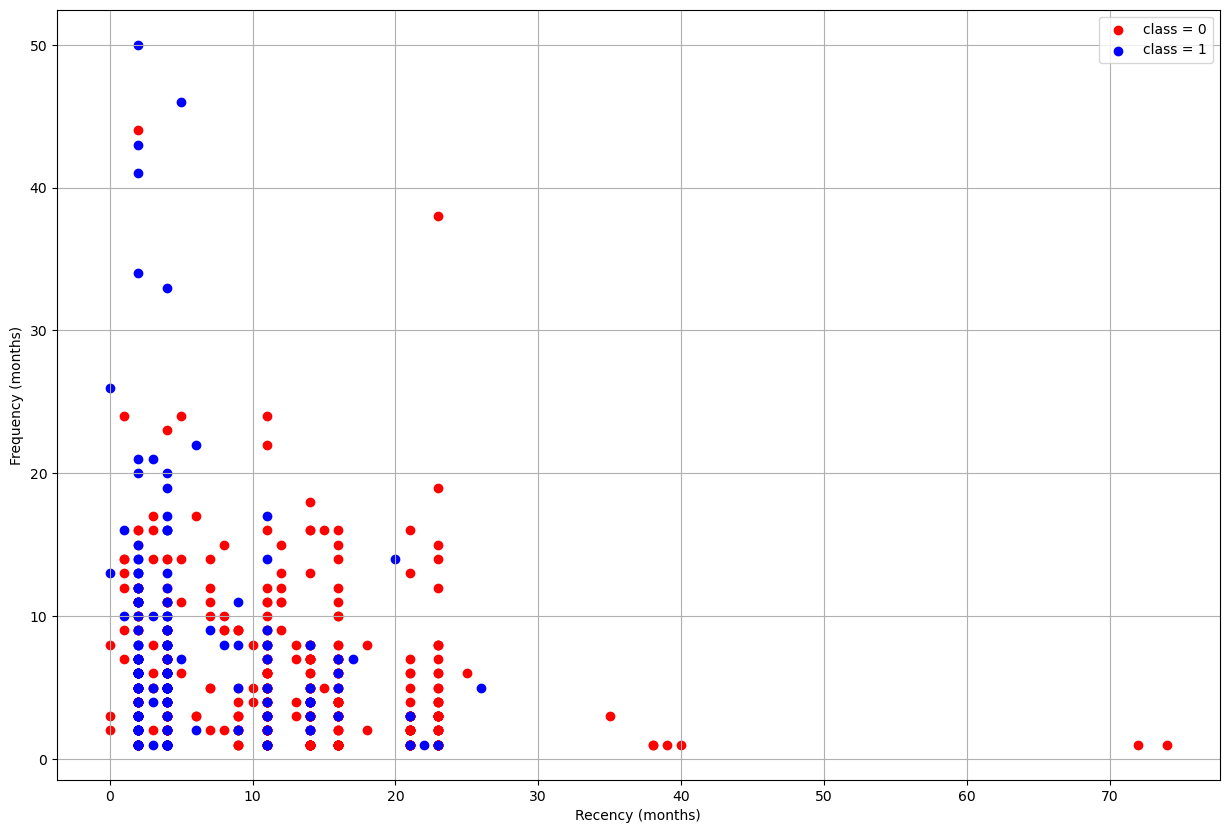

In [84]:


# plot the data showing the difference in the two classes 0 and 1
# make the graph bigger to see the data more clearly
# insert so that graph shows all intergers on the x and y axis
plt.figure(figsize=(15, 10))
plt.scatter(loc_df_class_0['months_since_last_donation'], loc_df_class_0['total_number_of_donations'], color='red', label='class = 0')
plt.scatter(loc_df_class_1['months_since_last_donation'], loc_df_class_1['total_number_of_donations'], color='blue', label='class = 1')
plt.xlabel('Recency (months)')
plt.ylabel('Frequency (months)')
plt.legend()
plt.grid()
plt.show()


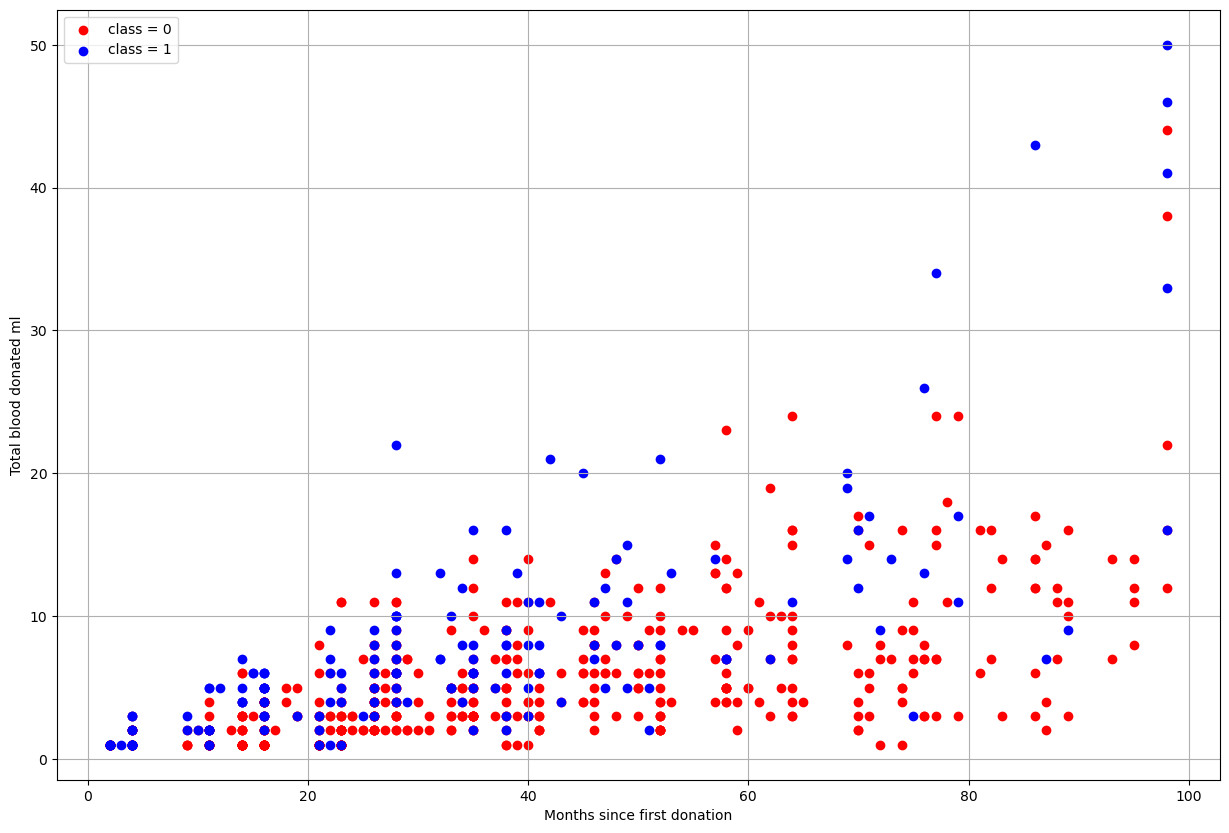

In [85]:
df.describe()
loc_df_class_0 = df.loc[df['class'] == 0]
loc_df_class_1 = df.loc[df['class'] == 1]

# plot the data showing the difference in the two classes 0 and 1
# make the graph bigger to see the data more clearly
# insert so that graph shows all intergers on the x and y axis
plt.figure(figsize=(15, 10))
plt.scatter(loc_df_class_0['months_since_first_donation'], loc_df_class_0['total_number_of_donations'], color='red', label='class = 0')
plt.scatter(loc_df_class_1['months_since_first_donation'], loc_df_class_1['total_number_of_donations'], color='blue', label='class = 1')
plt.xlabel('Months since first donation')
plt.ylabel('Total blood donated ml')
plt.legend()
plt.grid()

plt.show()

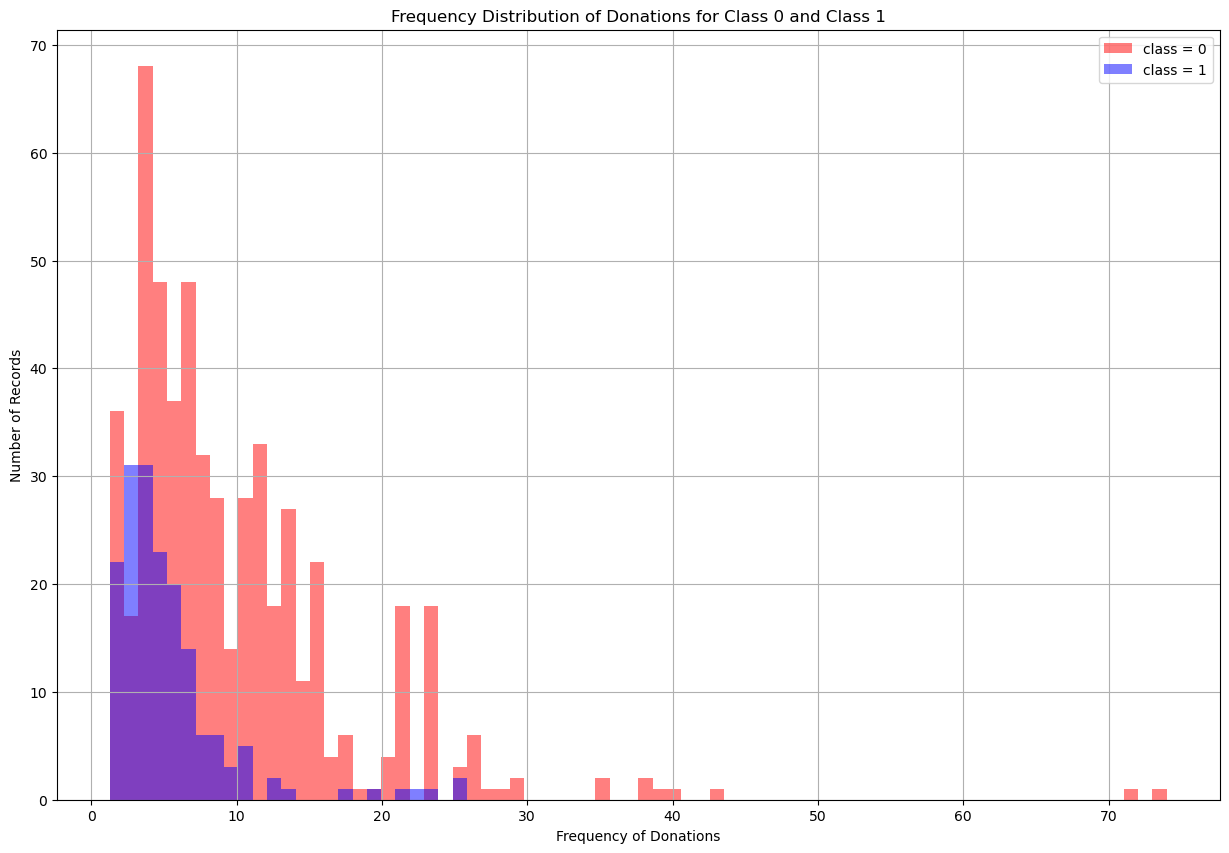

In [86]:
import numpy as np
import matplotlib.pyplot as plt

freq_class_0 = loc_df_class_0_with_freq['Average_frequency_donations']
freq_class_1 = loc_df_class_1_with_freq['Average_frequency_donations']

# Define the number of bins (adjust based on your data distribution)
bins = np.linspace(min(freq_class_0.min(), freq_class_1.min()), max(freq_class_0.max(), freq_class_1.max()), 75)

plt.figure(figsize=(15, 10))

# Create a histogram for class 0
hist_class_0, bins_class_0 = np.histogram(freq_class_0, bins=bins)
plt.bar(bins_class_0[:-1], hist_class_0, width=np.diff(bins_class_0), align='edge', color='red', alpha=0.5, label='class = 0')

# Create a histogram for class 1
hist_class_1, bins_class_1 = np.histogram(freq_class_1, bins=bins)
plt.bar(bins_class_1[:-1], hist_class_1, width=np.diff(bins_class_1), align='edge', color='blue', alpha=0.5, label='class = 1')

plt.xlabel('Frequency of Donations')
plt.ylabel('Number of Records')
plt.title('Frequency Distribution of Donations for Class 0 and Class 1')
plt.legend()
plt.grid()
plt.show()

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math

df_KNN = df.copy()
df_KNN_with_freq = df_with_freq.copy()

# Assuming df is your DataFrame and 'target' is the column with labels
X = df_KNN.drop(columns=['class'])
y = df_KNN['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # 80/20 split is good for big datasets where 20% is enough to test the model and 80% is enough to train the model
### DO THE IMBALANCE (o_o) ###

### CHECK FOR OUTLIERS ###

# standard scalar is by default z-score normalization
scaler = MinMaxScaler()
df_KNN = scaler.fit_transform(df_KNN)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)



print(df_KNN.min())
print(df_KNN.max())

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

df_NB = df.copy()
df_NB_with_freq = df_with_freq.copy()

# Assuming df is your DataFrame and 'target' is the column with labels
X = df_NB.drop(columns=['class'])
y = df_NB['class']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # 80/20 split is good for big datasets where 20% is enough to test the model and 80% is enough to train the model
### DO THE IMBALANCE ###

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
# print("Number of mislabeled points out of a total %d point : %d"
#       % (X_test.shape[0], (y_test != y_pred).sum()))


random_indices = X_test.sample(n=30, random_state=42).index
selected_cases = X_test.loc[random_indices]
actual_labels = y_test.loc[random_indices]
 
# CHANGE THE GNB FOR THE CORRESPONDENT ALGORITHM 
predicted_labels = gnb.predict(selected_cases)

for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report

df_SVC_MLP = df.copy()
df_SVC_MLP_with_freq = df_with_freq.copy()

# Assuming df is your DataFrame and 'target' is the column with labels
X = df_SVC_MLP.drop(columns=['class'])
y = df_SVC_MLP['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42) # 80/20 split is good for big datasets where 20% is enough to test the model and 80% is enough to train the model
### DO THE IMBALANCE (o_o) ###

### CHECK FOR OUTLIERS ###

# standard scalar is by default z-score normalization
scaler = StandardScaler()
df_SVC_MLP = scaler.fit_transform(df_SVC_MLP)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

df_SVC = df_SVC_MLP.copy()
svc_clf = svm.SVC()
svc_clf.fit(X_train_scaled,y_train)
y_pred_svc = svc_clf.predict(X_test_scaled)
# print(f'Accuracy: {accuracy_score(y_test, y_pred_svc)}')
# print(classification_report(y_test, y_pred_svc))

random_indices = X_test.sample(n=30, random_state=42).index
selected_cases = X_test.loc[random_indices]
actual_labels = y_test.loc[random_indices]
 
# CHANGE THE GNB FOR THE CORRESPONDENT ALGORITHM 
predicted_labels = svc_clf.predict(selected_cases)

for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")



Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


/Users/noahuddin/miniconda3/envs/Dat01/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


In [98]:
from sklearn.neural_network import MLPClassifier

df_MLP = df_SVC_MLP.copy()
mlp_clf = MLPClassifier(max_iter=1000, random_state=42)
mlp_clf.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_clf.predict(X_test_scaled)
# print(f'Accuracy: {accuracy_score(y_test, y_pred_mlp)}')
# print(classification_report(y_test, y_pred_mlp))


random_indices = X_test.sample(n=30, random_state=42).index
selected_cases = X_test.loc[random_indices]
actual_labels = y_test.loc[random_indices]
 
# CHANGE THE GNB FOR THE CORRESPONDENT ALGORITHM 
predicted_labels = mlp_clf.predict(selected_cases)

for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {actual_labels.iloc[i]}")

Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 1
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0


/Users/noahuddin/miniconda3/envs/Dat01/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
